In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import *

In [24]:
train = pd.read_csv('./datafile/train.csv')
train

,DATETIMEDATA,PM25,PM10,O3,CO,NO2,SO2,WS,TEMP,RH,WD
0,2024-01-01 00:00:00,11.5,20.0,23.00,0.20,1.00,0.00,2,28.0,86,15
1,2024-01-01 01:00:00,11.2,18.0,22.00,0.27,2.00,0.00,2,27.0,88,352
2,2024-01-01 02:00:00,9.8,17.0,19.00,0.26,3.00,0.00,2,27.0,90,348
3,2024-01-01 03:00:00,9.7,17.0,17.00,0.26,2.00,0.00,2,26.0,91,1
4,2024-01-01 04:00:00,8.7,16.0,17.00,0.26,2.00,0.00,2,27.0,90,3
...,...,...,...,...,...,...,...,...,...,...,...
1138,2024-02-18 06:00:00,15.6,32.0,14.00,0.05,3.00,0.00,1,25.0,85,30
1139,2024-02-18 07:00:00,17.7,37.0,7.00,0.07,2.29,0.00,0,25.0,84,274
1140,2024-02-18 08:00:00,21.4,48.0,18.00,0.20,2.00,0.14,2,29.0,64,56
1141,2024-02-18 09:00:00,16.3,41.0,22.86,0.16,1.00,0.00,4,31.0,57,60


In [25]:
test = pd.read_csv('./datafile/test.csv')
test

,DATETIMEDATA,PM25,PM10,O3,CO,NO2,SO2,WS,TEMP,RH,WD
0,2024-02-18 11:00:00,15.9,32.0,24.0,0.13,1.0,0.0,5,33.0,53,48
1,2024-02-18 12:00:00,12.6,33.0,27.0,0.14,1.0,0.0,5,33.0,51,49
2,2024-02-18 13:00:00,10.1,39.0,27.0,0.13,1.0,0.0,4,34.0,50,49
3,2024-02-18 14:00:00,8.7,34.0,28.0,0.13,1.0,0.0,5,33.0,51,52
4,2024-02-18 15:00:00,12.1,32.0,23.0,0.14,1.0,0.0,6,33.0,55,56
...,...,...,...,...,...,...,...,...,...,...,...
488,2024-03-09 19:00:00,6.5,22.0,13.0,0.11,3.0,0.0,2,29.0,73,39
489,2024-03-09 20:00:00,6.6,22.0,12.0,0.12,3.0,0.0,2,28.0,77,32
490,2024-03-09 21:00:00,6.2,21.0,12.0,0.12,3.0,0.0,2,27.0,80,31
491,2024-03-09 22:00:00,5.5,21.0,12.0,0.11,2.0,0.0,3,27.0,82,33


In [26]:
from pycaret.regression import *
train['DATETIMEDATA'] = pd.to_datetime(train['DATETIMEDATA'])
train = train.drop(columns=['TEMP','RH','WD','SO2'])

In [27]:
regression_setup = setup(train, target='PM25', session_id=123, date_features=['DATETIMEDATA'], normalize=True)
best = compare_models()
et_model = create_model('et')

,Description,Value
0,Session id,123
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(1143, 7)"
4,Transformed data shape,"(1143, 9)"
5,Transformed train set shape,"(800, 9)"
6,Transformed test set shape,"(343, 9)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.6806,7.0020,2.6209,0.8640,0.1497,0.1080,0.0610
rf,Random Forest Regressor,1.7330,7.1861,2.6566,0.8600,0.1523,0.1122,0.0870
gbr,Gradient Boosting Regressor,1.7810,7.3531,2.6871,0.8567,0.1533,0.1155,0.0450
lightgbm,Light Gradient Boosting Machine,1.8310,7.8977,2.7903,0.8467,0.1530,0.1137,0.5340
knn,K Neighbors Regressor,2.1541,9.7278,3.0918,0.8117,0.1716,0.1370,0.0160
ada,AdaBoost Regressor,2.5942,11.0764,3.3030,0.7836,0.1895,0.1691,0.0350
dt,Decision Tree Regressor,2.3320,13.1220,3.5855,0.7434,0.2014,0.1493,0.0140
br,Bayesian Ridge,2.4816,13.1239,3.6016,0.7381,0.1982,0.1592,0.0130
ridge,Ridge Regression,2.4792,13.1243,3.6016,0.7380,0.1982,0.1590,0.0100
lar,Least Angle Regression,2.4774,13.1253,3.6017,0.7380,0.1982,0.1589,0.0110


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6007,6.1343,2.4768,0.8833,0.1494,0.1011
1,1.5197,4.6516,2.1568,0.8876,0.1275,0.1002
2,2.0092,10.0934,3.1770,0.7914,0.1750,0.1223
3,1.5116,4.5909,2.1426,0.8932,0.1309,0.1013
4,1.6740,7.5032,2.7392,0.8493,0.1584,0.1129
5,2.0786,8.8802,2.9800,0.8525,0.1604,0.1311
6,1.7480,8.0517,2.8376,0.8464,0.1468,0.1035
7,1.5507,6.2758,2.5051,0.8785,0.1394,0.0991
8,1.6944,9.0865,3.0144,0.8538,0.1679,0.1071


In [28]:
tuned_et_model = tune_model(et_model)
bagged_model = ensemble_model(tuned_et_model, n_estimators=20)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:11:00
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8179,6.4558,2.5408,0.8772,0.1569,0.1234
1,2.0325,6.9352,2.6335,0.8324,0.1614,0.1382
2,2.0582,10.2069,3.1948,0.7890,0.1791,0.1330
3,1.7353,6.5132,2.5521,0.8485,0.1551,0.1241
4,1.9086,8.7010,2.9497,0.8253,0.1797,0.1376
5,2.5496,14.7926,3.8461,0.7543,0.1909,0.1635
6,1.8809,8.2374,2.8701,0.8429,0.1453,0.1116
7,1.9217,10.0952,3.1773,0.8046,0.1671,0.1219
8,2.0117,10.4294,3.2295,0.8322,0.1798,0.1279


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5900,5.8296,2.4145,0.8891,0.1448,0.1031
1,1.6811,5.1549,2.2704,0.8755,0.1335,0.1109
2,1.9289,9.1399,3.0232,0.8111,0.1661,0.1185
3,1.5037,4.7317,2.1752,0.8899,0.1338,0.1045
4,1.6658,7.4229,2.7245,0.8509,0.1613,0.1140
5,2.1065,9.4496,3.0740,0.8430,0.1602,0.1318
6,1.7242,7.8068,2.7941,0.8511,0.1439,0.1023
7,1.5220,6.1536,2.4806,0.8809,0.1399,0.0985
8,1.6388,8.9335,2.9889,0.8563,0.1651,0.1018


In [29]:
now = pd.Timestamp.now()
start_date = now.date()
end_date = start_date + pd.DateOffset(days=7)
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [30]:
future_data = pd.DataFrame({'DATETIMEDATA': future_dates})
future_data['PM10'] = train['PM10'].mean().round(2)
future_data['O3'] = train['O3'].mean().round(2)
future_data['CO'] = train['CO'].mean().round(2)
future_data['NO2'] = train['NO2'].mean().round(2)
future_data['WS'] = train['WS'].mean().round(2)

In [31]:
predictions = predict_model(bagged_model, data=future_data)
mpdf = pd.DataFrame(predictions, columns=['DATETIMEDATA', 'prediction_label'])
mpdf["prediction_label"] = mpdf["prediction_label"].round(2)
mpdf

,DATETIMEDATA,prediction_label
0,2024-03-14,17.40
1,2024-03-15,16.78
2,2024-03-16,17.30
3,2024-03-17,17.31
4,2024-03-18,17.50
5,2024-03-19,17.50
6,2024-03-20,17.50
7,2024-03-21,17.50


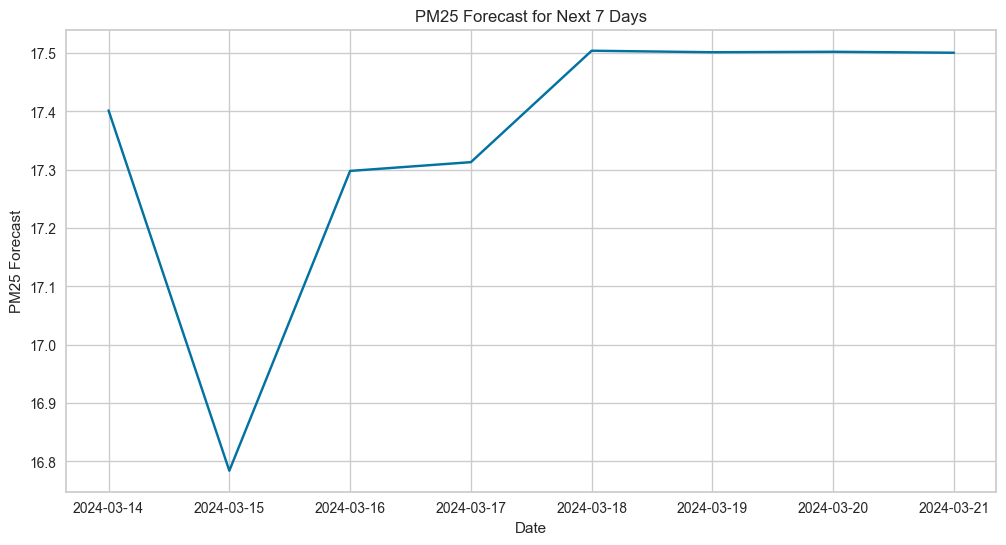

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions['prediction_label'])
plt.xlabel('Date')
plt.ylabel('PM25 Forecast')
plt.title('PM25 Forecast for Next 7 Days')
plt.grid(True)
plt.show()

In [33]:
save_model(bagged_model, 'PM25_pipeline')
load_model('PM25_pipeline')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\HP\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['DATETIMEDATA'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['PM10', 'O3', 'CO', 'NO2', 'WS'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('trained_model',
                 BaggingRegressor(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                random_state=123),
                                  n_estimators=20, random_state=123))])

In [34]:
mean_value = pd.read_csv('./datafile/mean_value.csv')
PM25_mean = mean_value.drop(columns=['PM10','O3','CO','NO2','SO2','WS','TEMP','RH','WD'])

In [35]:
mpdf = mpdf.rename(columns={"DATETIMEDATA": "Date", "prediction_label": "PM25"})
mpdf['Date'] = mpdf['Date'].dt.date
concat = pd.concat([PM25_mean, mpdf], ignore_index=True)
concat.to_csv('./datafile/PM25_mean_and_week_forecast.csv', index=True)

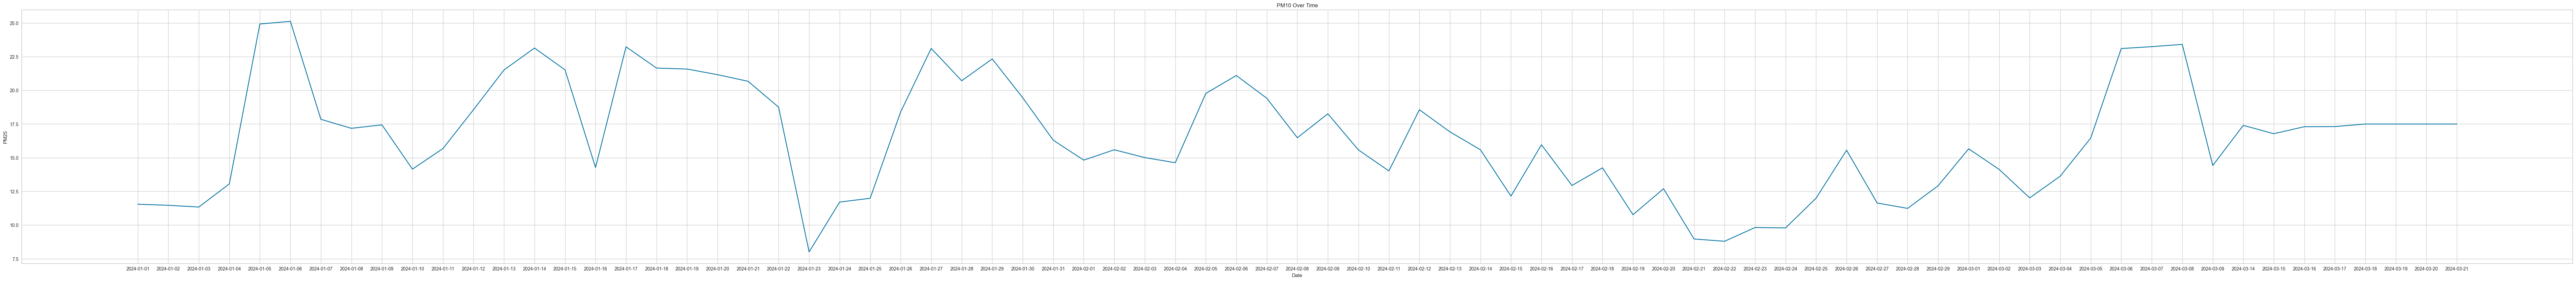

In [36]:
PM25_mean_and_week_forecast = pd.read_csv('./datafile/PM25_mean_and_week_forecast.csv')
dates = PM25_mean_and_week_forecast['Date']
pm10 = PM25_mean_and_week_forecast['PM25']
plt.figure(figsize=(100, 10))
plt.plot(dates, pm10)
plt.xlabel('Date')
plt.ylabel('PM25')
plt.title('PM10 Over Time')
plt.grid(True)
plt.show()
plt.show()

In [37]:
evaluate_model(bagged_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [38]:
test['DATETIMEDATA'] = pd.to_datetime(test['DATETIMEDATA'])
pre_PM25_test = predict_model(bagged_model,data=test)
pre_PM25_test

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bagging Regressor,3.7697,20.4604,4.5233,0.5615,0.3379,0.3676


,DATETIMEDATA,PM10,O3,CO,NO2,SO2,WS,TEMP,RH,WD,PM25,prediction_label
0,2024-02-18 11:00:00,32.0,24.0,0.13,1.0,0.0,5,33.0,53,48,15.9,14.45095
1,2024-02-18 12:00:00,33.0,27.0,0.14,1.0,0.0,5,33.0,51,49,12.6,13.39240
2,2024-02-18 13:00:00,39.0,27.0,0.13,1.0,0.0,4,34.0,50,49,10.1,16.46960
3,2024-02-18 14:00:00,34.0,28.0,0.13,1.0,0.0,5,33.0,51,52,8.7,13.36420
4,2024-02-18 15:00:00,32.0,23.0,0.14,1.0,0.0,6,33.0,55,56,12.1,13.29465
...,...,...,...,...,...,...,...,...,...,...,...,...
488,2024-03-09 19:00:00,22.0,13.0,0.11,3.0,0.0,2,29.0,73,39,6.5,12.46300
489,2024-03-09 20:00:00,22.0,12.0,0.12,3.0,0.0,2,28.0,77,32,6.6,12.44770
490,2024-03-09 21:00:00,21.0,12.0,0.12,3.0,0.0,2,27.0,80,31,6.2,12.24630
491,2024-03-09 22:00:00,21.0,12.0,0.11,2.0,0.0,3,27.0,82,33,5.5,12.22895


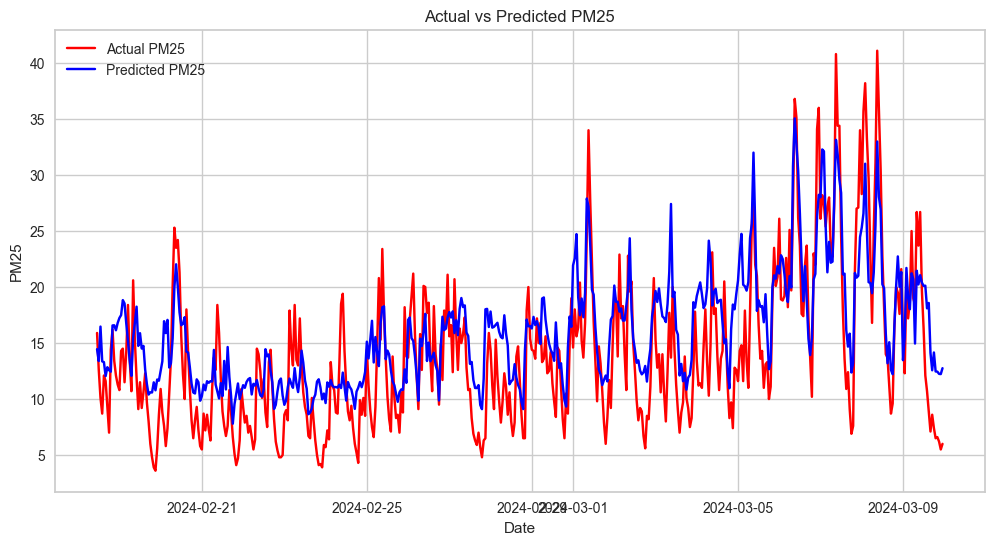

In [39]:

import matplotlib.pyplot as plt
test['DATETIMEDATA'] = pd.to_datetime(test['DATETIMEDATA'])

test = test.sort_values('DATETIMEDATA')
predictions = predictions.sort_values('DATETIMEDATA')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(pre_PM25_test['DATETIMEDATA'], pre_PM25_test['PM25'], color='red', label='Actual PM25')
plt.plot(pre_PM25_test['DATETIMEDATA'], pre_PM25_test['prediction_label'], color='blue', label='Predicted PM25')
plt.xlabel('Date')
plt.ylabel('PM25')
plt.title('Actual vs Predicted PM25')
plt.legend()
plt.show()

In [40]:
import pandas as pd

pre_PM25_test['percentage_difference'] = (abs(pre_PM25_test['PM25'] - pre_PM25_test['prediction_label']) / pre_PM25_test['PM25']) * 100

average_percentage_difference = pre_PM25_test['percentage_difference'].mean()
print(f'Average percentage difference: {average_percentage_difference:.2f}%')

pre_PM25_test = pre_PM25_test.drop(columns=['DATETIMEDATA','PM10','O3','CO','NO2','SO2','WS','TEMP','RH','WD'])
pre_PM25_test

Average percentage difference: 36.76%


,PM25,prediction_label,percentage_difference
0,15.9,14.45095,9.113520
1,12.6,13.39240,6.288886
2,10.1,16.46960,63.065338
3,8.7,13.36420,53.611498
4,12.1,13.29465,9.873138
...,...,...,...
488,6.5,12.46300,91.738462
489,6.6,12.44770,88.601518
490,6.2,12.24630,97.520975
491,5.5,12.22895,122.344546
